# Importer les librairies

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Importer les données

In [2]:
data = pd.read_csv("./titanic.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Questions

## 1. Préparation des données

Remplissez la function `preprocess` ci-dessus. Celle-ci doit:
1. Supprimez les colonnes `PassengerId`, `Name`, `Ticket`, `Cabin`.
2. Supprimez les lignes contenant au moins une valeur manquante.
3. Créer une variable `FamilySize` qui est correspond à `SibSp` + `Parch` + 1. Supprimez les variables `SibSp` et `Parch`.
4. Recalculer le prix du billet `Fare` en divisant `Fare` par `FamilySize`.
5. Encoder les variables qualitatives `Sex` et `Embarked` avec l'argument `drop_first=True`.

In [4]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame:
    
    """La fonction prépare les données à l'analyse.
    
    Args:
        data (pd.DataFrame): La dataframe originale
        
    Returns:
        pd.DataFrame: La dataframe preprocessé et prête à être analysée.
    """
    
    # Faire une copy de la dataframe originale
    data_preprocessed = data.copy()
    
    # Supprimez les variables `PassengerId`, `Name`, `Ticket` & `Cabin`
    data_preprocessed.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)
    
    # Supprimez lignes contenant au moins une valeur manquante
    data_preprocessed.dropna(axis=0, inplace=True) # on supprime les lignes (axe 0) et pas les colonnes 
    
    # Créer une variable `FamilySize` et supprimez les variables `SibSp` et `Parch`
    data_preprocessed['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data_preprocessed.drop(columns=['SibSp', 'Parch'], inplace=True)
    
    # Recalculer le prix du billet
    data_preprocessed['Fare'] = data_preprocessed['Fare'] / data_preprocessed['FamilySize']
    
    # Encoded (OHE) `Sex` et `Embarked`
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=['Sex', 'Embarked'], drop_first=True, dtype=int)
    
    
    # CHECK: NE PAS TOUCHER
    for col in ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"]:
        assert col not in data_preprocessed, f"{col} n'a pas été retiré."
    assert data_preprocessed.isna().sum().sum() == 0, "Il reste encore des NaN à supprimer."
    assert "FamilySize" in data_preprocessed.columns, "La colonne `FamilySize` n'a pas été créée."
    assert data_preprocessed.loc[0, "Fare"] == 3.625, "La colonne `Fare` n'a pas été recalculée."
    for col in [col for col in data_preprocessed if col.startswith("Embarked")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    for col in [col for col in data_preprocessed if col.startswith("Sex")]:
        assert data_preprocessed[col].nunique() == 2, f"{col} n'a pas été encodé."
    
    return data_preprocessed

Le résultat de la function doit vous donner exactement le tableau ci-dessous.

In [5]:
# Preprocess les données à l'aide de la function `preprocess`
data_clean = preprocess(data)
display(data_clean)

,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,3.625000,2,1,0,1
1,1,1,38.0,35.641650,2,0,0,0
2,1,3,26.0,7.925000,1,0,0,1
3,1,1,35.0,26.550000,2,0,0,1
4,0,3,35.0,8.050000,1,1,0,1
...,...,...,...,...,...,...,...,...
885,0,3,39.0,4.854167,6,0,1,0
886,0,2,27.0,13.000000,1,1,0,1
887,1,1,19.0,30.000000,1,0,0,1
889,1,1,26.0,30.000000,1,1,0,0


## 2. Inférence statistique (4 pts)

In [6]:
# variables globales
ALPHA = 0.05

**Q1: L'âge moyen des passagers du Titanic est-il est le même que l'âge moyen de la population en 1912 (28 ans)?**

## Q1
La variable d'intérêt ici est "Age", qui est une variable quantitative continue.

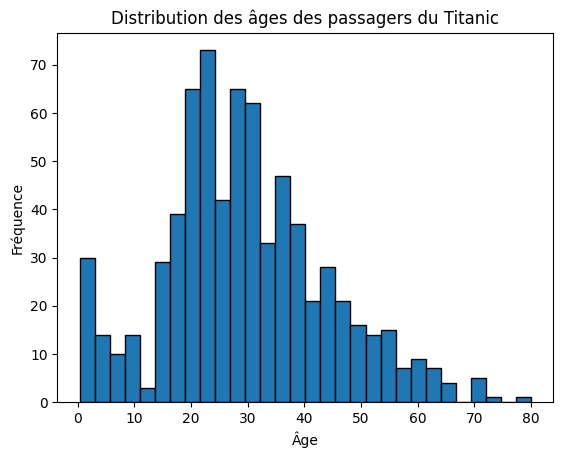

In [7]:
plt.hist(data_clean['Age'], bins=30, edgecolor='black')
plt.title('Distribution des âges des passagers du Titanic')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.show()

Hypothèse nulle et alternative :
H0: μ = 28
H1: μ != 28

Le test statistique approprié est le t-test

In [9]:
# moyenne de l'âge de la population en 1912
mu = 28
# âge des passagers du Titanic
age = data_clean['Age']

t, p_valeur = stats.ttest_1samp(age, popmean=mu)
sample_mean = np.mean(age)
d_cohen = (sample_mean - mu) / np.std(age)

print(f"La statistique t est de : {round(t, 3)}")
print(f"La p-valeur associée est de : {round(p_valeur, 3)}")
if p_valeur < ALPHA:
    print(f"Avec un seuil alpha {ALPHA}, on rejète l'hypothèse nulle.")
else:
    print(f"Avec un seuil alpha {ALPHA}, on ne rejète pas l'hypothèse nulle.")
print(f"Moyenne d'âge de l'échantillon : {round(sample_mean, 3)}")
print(f"Taille de l'effet (d de Cohen) : {round(d_cohen, 3)}")

La statistique t est de : 3.023
La p-valeur associée est de : 0.003
Avec un seuil alpha 0.05, on rejète l'hypothèse nulle.
Moyenne d'âge de l'échantillon : 29.642
Taille de l'effet (d de Cohen) : 0.113


### Interprétation des résultats et évalutaion de la taille des effets:
L'âge moyen des passagers du Titanic est statistiquement significativement différent de 28 ans, mais la différence d'âge moyen entre les passagers du Titanic et la population en 1912 est petit en terme d'écart-type.

Cela pourrait suggérer que l'âge des passagers du Titanic reflétait assez bien la distribution des âges dans la population en général en 1912, même si l'âge moyen était légèrement différent.

**Q2: La survie dépend-elle de la classe du passager?**

Les variables d'intérêts sont la variable de survie et la classe du passager. Ces deux variables sont qualitatives: nominale pour "Survived" et ordinale pour "Pclass".

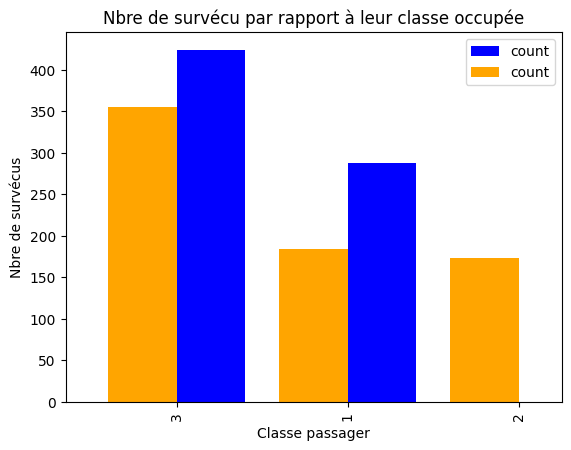

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Créer un diagramme en barres
fig, ax = plt.subplots()

# Barres pour la variable nominale
data_clean['Survived'].value_counts().plot(kind='bar', position=0, width=0.4, ax=ax, color='blue')

# Barres pour la variable ordinale
data_clean['Pclass'].value_counts().plot(kind='bar', position=1, width=0.4, ax=ax, color='orange')

# Réglages du graphique
ax.set_xlabel('Classe passager')
ax.set_ylabel('Nbre de survécus')
ax.set_title('Nbre de survécu par rapport à leur classe occupée')
ax.legend()

# Afficher le diagramme
plt.show()


Hypothèse nulle et alternative :
H0: μ = La survie d'un passager et le type de sa classe sont indépendantes l'un de l'autre.
H1: μ != La survie d'un passager et le type de sa classe ne sont pas indépendantes l'un de l'autre.
Le test statistique approprié ici est le 𝜒2 independence test ou "chi-square".

**Q3: Existe-t-il une différence d'âge entre les passagers qui ont survécu et les passagers décédés?**

Les variables d'intérêt son ici Age (variable quantitative continue) et Survived (variable quanlitative catégorielle)

([<matplotlib.axis.XTick at 0x7f711b9050d0>,
 [Text(0, 0, 'Died'), Text(1, 0, 'Survived')])

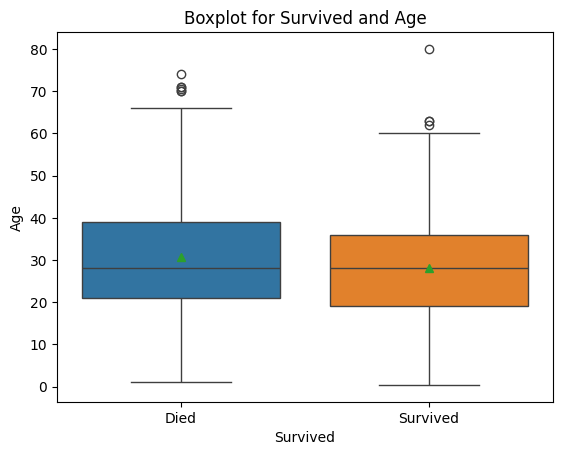

In [11]:
sns.boxplot(
    x='Survived', 
    y='Age', 
    data=data_clean,
    showmeans=True,
    hue='Survived',
    legend=False,
)
plt.title("Boxplot for Survived and Age")
plt.xticks(ticks=[0,1], labels=['Died', 'Survived'])

Hypothèse nulle et alternative :
Hypothèse nulle (H0) : Il n'y a pas de différence significative entre l'âge des passagers qui ont survécu et ceux qui sont décédés.
Hypothèse alternative (H1) : Il y a une différence significative entre l'âge des passagers qui ont survécu et ceux qui sont décédés

Le test statistique approprié est le two-samplple t-test

In [12]:
survived = data_clean[data_clean['Survived'] == 1]['Age']
died = data_clean[data_clean['Survived'] == 0]['Age']

t, p_valeur = stats.ttest_ind(
    survived,
    died,
    alternative="two-sided",
    equal_var=False
)
survived_mean = np.mean(survived)
died_mean = np.mean(died)
variance_survived = np.var(survived, ddof=1)
variance_died = np.var(died, ddof=1)
n_survived = len(survived)
n_died = len(died)
d_cohen = (np.mean(survived) - np.mean(died)) / np.sqrt(((n_survived-1)*variance_survived + (n_died-1)*variance_died) / (n_survived+n_died-2))

print(f"La moyenne d'âge des survivants est de : {round(survived_mean, 3)}")
print(f"La moyenne d'âge des non-survivants est de : {round(died_mean, 3)}")
print(f"La statistique t est de : {round(t, 3)}")
print(f"La p-valeur associée est de : {round(p_valeur, 3)}")
if p_valeur < ALPHA:
    print(F"Avec un seuil alpha {ALPHA}, on rejète l'hypothèse nulle.")
else:
    print(f"Avec un seuil alpha {ALPHA}, on ne rejète pas l'hypothèse nulle.")
print(f"Taille de l'effet (d de Cohen) : {round(d_cohen, 3)}")

La moyenne d'âge des survivants est de : 28.193
La moyenne d'âge des non-survivants est de : 30.626
La statistique t est de : -2.184
La p-valeur associée est de : 0.029
Avec un seuil alpha 0.05, on rejète l'hypothèse nulle.
Taille de l'effet (d de Cohen) : -0.168


### Interprétation des résultats et évalutaion de la taille des effets:
Il semble y avoir une différence significative entre l'âge des passagers qui ont survécus et ceux qui sont décédés lors du naufrage, les survivants étant en moyenne plus jeunes. Malgré cela, l'âge n'a pas forcément directement influencé les chances de survie. Le d de Cohen suggère qu'il y a une petite différence statistiquement significative entre l'âge moyen des survivants et des non-survivants sur le Titanic.

**Q4: Existe-t-il une relation entre l'âge des passagers et le prix des billets?**

Pour chacune des questions 1 à 4 ci-dessus, argumenter de manière statistique en effectuant chacune des étapes suivantes:
1. Identifier la ou les variables d'intérêt et spécifier le type.
2. Réaliser une visualisation appropriée selon la ou les variables.
3. Enoncer une hypothèse nulle et une hypothèse alternative considérant la ou les variables identifiées.
4. Identifier le test statistique approprié selon les hypothèses énoncées.
5. Vérifier la validation des assumptions selon le test identifié.
6. Calculer la statistique ainsi que la p-valeur.
7. Prendre une décision à partir de la p-valeur et d'un seuil alpha de 5%.
8. Interpréter le résultat et évaluer la taille de l'effet.

Quelques liens utiles pour la taille de l'effet:
* [https://rpsychologist.com/cohend/](https://rpsychologist.com/cohend/)
* [https://datatab.net/tutorial/effect-size-independent-t-test](https://datatab.net/tutorial/effect-size-independent-t-test)
* [https://www.simplypsychology.org/effect-size.html](https://www.simplypsychology.org/effect-size.html)

## 3. Data mining (2 pts)

**Q1: Effectuer une analyse statistique à l'aide de la régression logistique avec comme variable dépendente la variable `Survived`. Interpréter les coefficients et discuter de leur importance statistique en vous appuyant sur leur p-valeur.**

**Q2: Effecter une analyse statistique à l'aide d'un arbre de classification avec comme variable dépendente la variable `Survived` et une profondeur maximale de 4. Visualiser l'arbre et expliquer quelques décisions.**

**Conclusion: Interpréter les résultats des deux analyses statistiques et résumer les points importants de votre étude.**